# Compute tech. potential and sanity-check load shapes
### First make sure to update dr-path local.py file to reflect region and path to database

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from dr_path.db import models, io
from dr_path import settings
#%matplotlib notebook

In [2]:
#Open database
outdir = '/mnt/c/Users/bgerke.DOMINO0/Desktop/q4 briefing figures'
try:
    models.database.close()
except:
    pass

db_file = os.path.join(settings.OUTPUT_DIR, settings.DB_NAME)
print(db_file)
models.database.init(db_file)

models.database.connect()

print(outdir)

/home/bgerke/bgerke.DOMINO0/Desktop/dr_path_btot2/NENG/dr_path_NENG.db
/mnt/c/Users/bgerke.DOMINO0/Desktop/q4 briefing figures


In [3]:
models.CLSFeature.select().count()

12576

In [4]:
db_file

'/home/bgerke/bgerke.DOMINO0/Desktop/dr_path_btot2/NENG/dr_path_NENG.db'

In [5]:
#Mapping for WS to city name
city_tweak = {'Midland Midland':'Midland', 'Lubbock Lubbock':'Lubbock', 'Dallas Fort':'Dallas', 
              'Shreveport Regional':'Shreveport, LA', 'Abilene Municipal':'Abilene', 
              'Amarillo Intl':'Amarillo',
              'Angelina Co':'Angelina', 'Austin Mueller':'Austin', 'Brownsville Intl':'Brownsville',
              'Houston Intercontin':'Houston',
              'Victoria Victoria':'Victoria', 'Waco Rgnl':'Waco', 
              'Barstow Daggett': 'Barstow', 'Bakersfield Meadows':'Bakersfield', 
              'Fresno Air':'Fresno', 'Reno Cannon':'Reno',
              'Sacramento Executiv': 'Sacramento',
              'Hartford Bradley': 'Hartford, CT', 
              'Boston Logan': 'Boston, MA', 
              'Portland Intnl': 'Portland, ME', 
              'Concord Municipal': 'Concord, NH', 
              'Burlington Intl': 'Burlington, VT',
              'Providence Green': 'Providence, RI',
              'Albany County': 'Albany, NY'}

#Lists of cities to keep
if settings.REGION == 'CAMX':
    cities=['Arcata', 'Bakersfield', 'Barstow', 'Fresno', 
            'Los Angeles', 'Sacramento', 'San Francisco']
elif settings.REGION=='ERCT':
    cities = ['Abilene','Amarillo','Brownsville', 'Corpus Christi',  
              'Dallas', 'Houston', 'Shreveport, LA']
elif settings.REGION=='NENG':
    cities = ['Hartford, CT', 'Providence, RI', 'Boston, MA', 'Albany, NY',
              'Burlington, VT', 'Concord, NH', 'Portland, ME']
    
    
region_mapping = {'CAMX': 'California', 
                  'ERCT': 'Texas',
                  'NENG': 'New England'}


In [6]:
dem = models.DemandScenario.get(id=1)
tou = models.TOUImpactScenario.get(id=1)
ren = models.RenewableScenario.get(id=1)
tech = models.TechnologyScenario.get(id=1)

In [7]:
def get_data_for_plots(dr_type, btypes=['Single-Family Detached'], sys_group='end_use'):
    clsf = io.modelselect2dataframe(models.CLSFeature.select(
            models.CLSFeature.value, 
            models.CLSFeature.event_hours,
            models.Cluster.name.alias('cluster'),
            models.Cluster.region, 
            models.Cluster.building_type,
            models.Cluster.customer_count,
            models.EndUse.name.alias('end_use'),
            models.DemandScenario.name.alias('demand_scenario')).join(
                models.ClusterLoadShape).join(models.Cluster).switch(
                models.ClusterLoadShape).join(models.EndUse).switch(
                models.CLSFeature).join(models.DemandScenario).where(
                    (models.CLSFeature.dr_type==dr_type) & (models.Cluster.sector=='res') &
                    (models.CLSFeature.timescale=='year') &
                    ~(models.EndUse.name << ['battery', 'total'])))
    #Map hvac back to cooling (need to fix this in dr-path)
    clsf.loc[clsf['end_use']=='hvac', 'end_use']='cooling'

    if dr_type=='shift':
        #Get the longest-duration shifts
        max_dur = clsf['event_hours'].unique().max()
        clsf = clsf.loc[clsf['event_hours']==max_dur]
    #Get list of demand scenarios
    ds_list = clsf['demand_scenario'].unique()
    ds_list.sort()
    #create a map to reanme the demand scenarios
    ds_name_map = dict(zip(ds_list,['Base','Equipment','Controls','Envelope','Cont.+Env.','All']))

    #Parse city names
    clsf['city'] = clsf['region'].str.split('_').str[2].str.split('.').str[0:2].str.join(' ').values


    #Reshape data to plot building-level technical potential
    clsf_sfd = clsf.loc[clsf['building_type'].isin(btypes)].groupby(
        ['city', 'demand_scenario']).agg({'value':'sum', 'customer_count':'mean'})

    #Compute potential per building and difference from baseline
    clsf_sfd['value_bldg'] = clsf_sfd['value']/clsf_sfd['customer_count']
    clsf_sfd['diff_bldg'] = 0
    for c,d in clsf_sfd.index:
        clsf_sfd.loc[(c,d),'diff_bldg'] = (clsf_sfd.loc[(c,d),'value_bldg'] - 
                                           clsf_sfd.loc[(c,ds_list[0]),'value_bldg'])
        
    #Reshape data for building-level plot
    bldg_plot_data = clsf_sfd['diff_bldg'].unstack().rename(
        index=city_tweak,
        columns=ds_name_map).reindex(cities).drop(columns='Base')
    
   
    sys_plot_data = clsf.groupby(['demand_scenario',sys_group])['value'].sum().div(1.e6).unstack(0)
    sys_plot_data.columns=('Base', 'Equipment','Controls','Envelope','Cont.+Env.', 'All')
    sys_plot_data.index=sys_plot_data.index.str.replace('_',' ').str.capitalize()
    
    #Get savings values
    clus = io.modelselect2dataframe(models.Cluster.select(
    models.Cluster.name.alias('cluster'),
    models.DemandScenario.name.alias('demand_scenario'),
    models.Cluster.kwh_ann_tot).join(models.DemandScenario).where(
        models.Cluster.sector=='res'))
    savings = clus.groupby('demand_scenario')['kwh_ann_tot'].sum()
    savings = (savings/savings.iloc[0])
    savings.index=('Base', 'Equipment','Controls','Envelope','Cont.+Env.', 'All')
    savings=savings.reset_index()
    

    
    return bldg_plot_data, sys_plot_data, savings

In [8]:
#Get a dataframe of dr features for each modeled cluster of buildings. 
#These are the cluster load shape features (or clsf for short)

#Create figure
fig,axs = plt.subplots(2,1, figsize=[16,20], sharex=True)

incl_cols = ['Equipment', 'Controls','Envelope', 'Cont.+Env.','All']
colors = ['darkcyan', 'firebrick', 'mediumblue', 'darkviolet', 'dimgray']

plot_data = {}

for i, dr_type in enumerate(['shed', 'shift']):
    plot_data[dr_type] = get_data_for_plots(dr_type)
    ax=axs[i]
    ax.axhline(color='k', linestyle=':')
    plot_data[dr_type][0][incl_cols].plot(
        kind='bar', edgecolor='k', linewidth=2, color=colors, 
        fontsize=36, grid=True,ax=ax, legend=False)

    ax.set_axisbelow(True)
    ax.set_facecolor("lightgray")
    ax.set_ylabel(
        "Change from base scenario (kW{h})".format(
            h=('h' if dr_type=='shift' else '')), 
        fontsize=30)
    ax.set_xlabel('')
    ax.text(0.875,0.05,dr_type.capitalize(), transform=ax.transAxes, fontsize=40)


axs[0].set_title("Technical potential per SFD home: "+region_mapping[settings.REGION], fontsize=36)
axs[0].legend(loc='upper left', bbox_to_anchor=[1.01,1], fontsize=30)
plt.subplots_adjust(hspace = 0.1)

plt.savefig(os.path.join(outdir, 'Level_1a_change_{r}.png'.format(r=settings.REGION)),
           bbox_inches='tight')
#plt.tight_layout()
#plot_data.mul(0).plot(use_index=True, ax=ax, color='k', linestyle='-.', legend=False)
#clsf_sfd['diff_bldg'].plot(kind='bar', ax=ax)#['cluster'].iloc[1]
#clsf_sfd.loc[clsf['demand_scenario']==ds_list[0],'value']-clsf.loc[]

In [9]:
plot_data['shed'][0]

demand_scenario  Equipment  Controls  Envelope  Cont.+Env.       All
city                                                                
Hartford, CT     -0.598828 -0.045878 -0.646117   -0.599953 -1.308780
Providence, RI   -0.603861 -0.029391 -0.565740   -0.504027 -1.248424
Boston, MA       -0.621155 -0.029251 -0.637264   -0.558970 -1.335967
Albany, NY       -0.908946 -0.077184 -0.800943   -0.709355 -1.701545
Burlington, VT   -0.615173 -0.049301 -0.415363   -0.306110 -1.106049
Concord, NH      -0.632733 -0.040571 -0.516093   -0.455138 -1.253589
Portland, ME     -0.605602 -0.041713 -0.438509   -0.376689 -1.126482

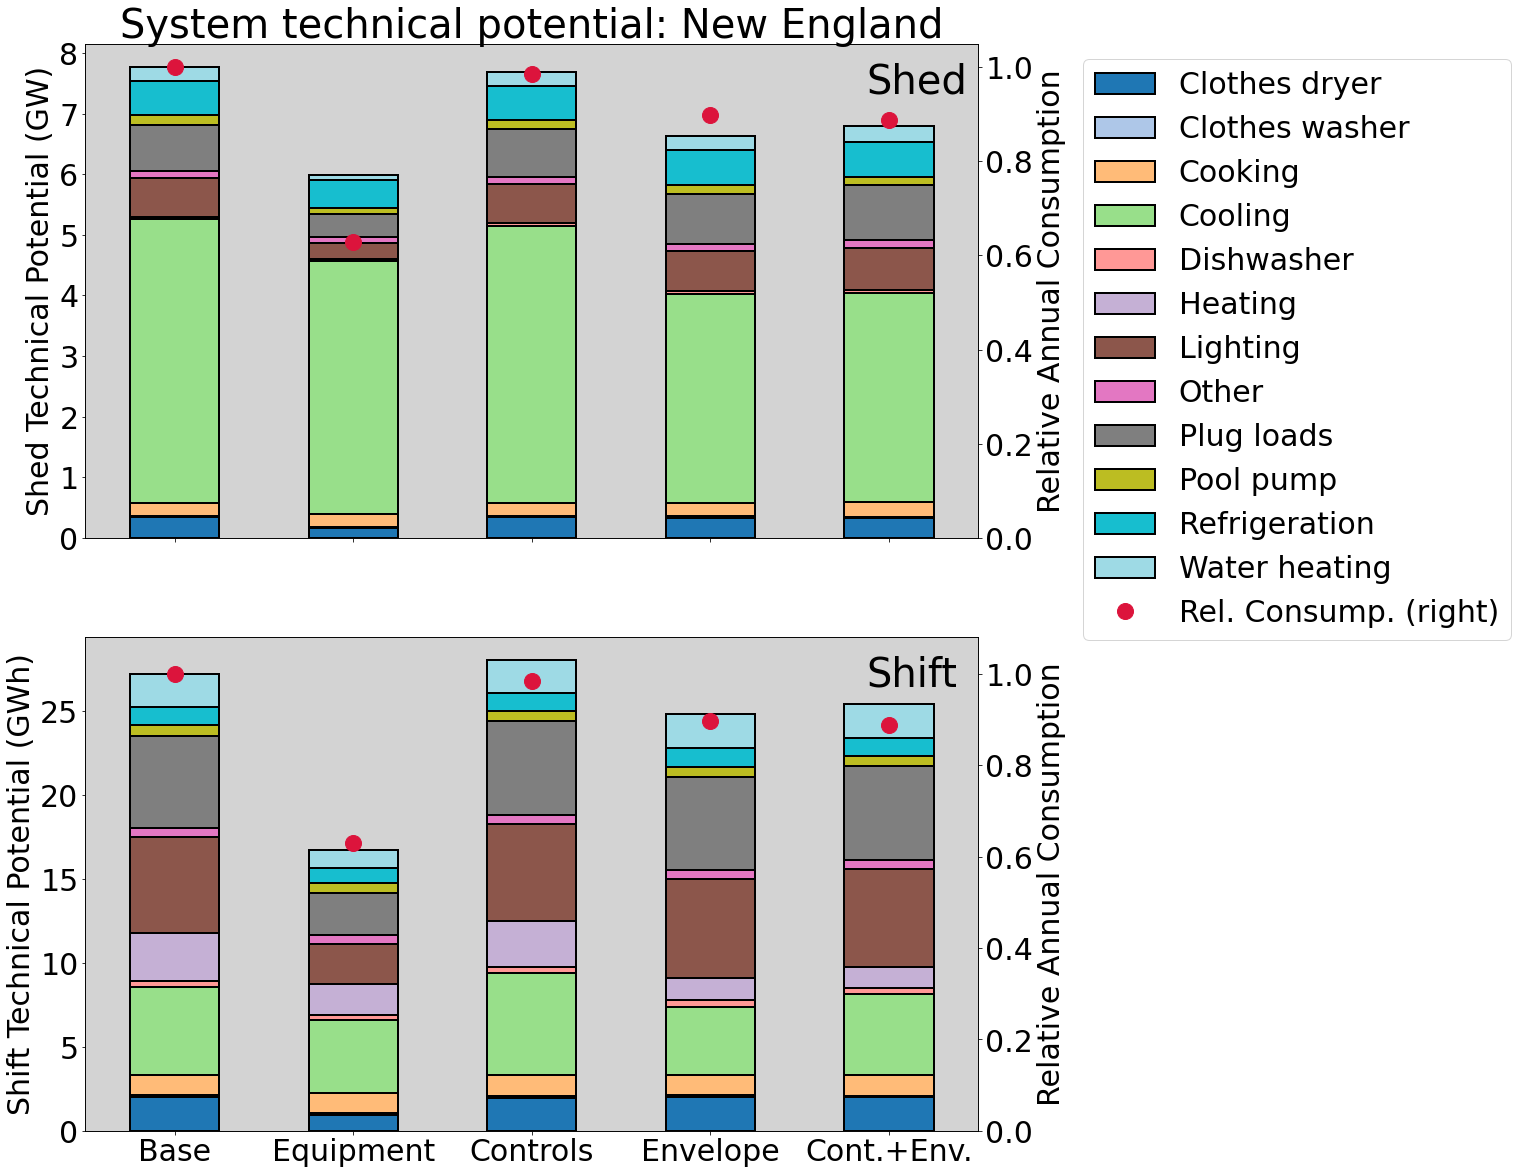

In [10]:
fig, axs = plt.subplots(2,1, figsize=(16,20))

plot_ports = ['Base', 'Equipment', 'Controls', 'Envelope', 'Cont.+Env.',]# 'All']

for i,dr_type in enumerate(['shed','shift']):
    #Do we want to keep or drop lighting from the Shift plot?
    if False:#dr_type=='shift':
        drop_rows=['lighting']
    else:
        drop_rows=[]
    ax=axs[i]

    features=plot_data[dr_type][1]
    features.drop(index=drop_rows)[plot_ports].T.plot.bar(
        stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
                        linewidth=2, 
                        fontsize=30,# grid=True,
                        ax=ax, zorder=1.5)

    ax.set_axisbelow(True)
    #ax.scatter(savings['index'], savings['kwh_ann_tot'], secondary_y=True)
    savings=plot_data[dr_type][2]
    ax2 = savings.loc[savings['index'].isin(plot_ports)].plot(
        x='index', y='kwh_ann_tot', secondary_y=True, ax=ax, 
                 marker='o', markersize=16, linestyle='', color='crimson',# grid=True, 
                                                        fontsize=30, label='Rel. Consump. (right)', legend=False)


    
    #ax.grid(True, zorder=0)
    #ax2.set_axisbelow(True)

    ax.set_facecolor("lightgray")
    ax.set_ylabel('{t} Technical Potential (GW{h})'.format(
        t=dr_type.capitalize(), h=('h' if dr_type=='shift' else '')), fontsize=30)
    ax2.set_ylabel('Relative Annual Consumption', fontsize=30)
    ax.set_xlabel(None)
    yl = ax.get_ylim()
    ax2.set_ylim([0, yl[1]/features['Base'].sum()])
    ax.text(0.875,0.9,dr_type.capitalize(), transform=ax.transAxes, fontsize=40)
    
lns, lbs = ax.get_legend_handles_labels()
lns2, lbs2 = ax2.get_legend_handles_labels()
axs[0].legend(lns+lns2, lbs+lbs2, loc='upper left', bbox_to_anchor=[1.1,1], fontsize=30)
axs[0].set_title('System technical potential: {r}'.format(r=region_mapping[settings.REGION]), 
                 fontsize=40)
fig.savefig(os.path.join(outdir, 'System_tech_potential_{r}'.format(r=settings.REGION)),
           bbox_inches='tight')

In [11]:
dem = models.DemandScenario.get(id=1)
tou = models.TOUImpactScenario.get(id=1)
ren = models.RenewableScenario.select().where(models.RenewableScenario.weather ==
                                          dem.weather)[0]
ts = models.TechnologyScenario.get(name='Base')
sup = io.get_supply_curve(dem, tou, ren, ts, year=2016, timescale='year', 
                          dr_type='shed', disaggregate_by=['sector','end_use'])
sup

sector                      res                            
end_use           clothes_dryer       cooling water_heating
procurement_price                                          
50.0                   0.000000   2464.574059      0.000000
100.0                  0.000000  74401.764742      0.000000
150.0                  0.000000  86297.229414      0.000000
200.0                  0.000000  91235.821413      0.000000
250.0                 17.989082  94507.504857      0.000000
300.0                 87.488500  94556.466976      0.000000
350.0                448.032626  94556.466976      0.000000
400.0               6918.810244  94556.466976      2.705843
450.0               8318.259464  94556.466976     13.350959
500.0               8868.383449  94556.466976     25.033899

In [12]:
plot_barchart = (sup/(1000**2)).plot.barh(stacked=True)
lines, labels = plot_barchart.get_legend_handles_labels()
plot_barchart.legend(bbox_to_anchor=(1.0,1.0))
hlabel = 'h' if dr_type=='shift' else ''
plt.xlabel("{t} DR potential (GW{h}-year)'".format(t=dr_type, h=hlabel))
plt.ylabel("Procurement Price ($/kW{h}-year)".format(h=hlabel))
plt.show()

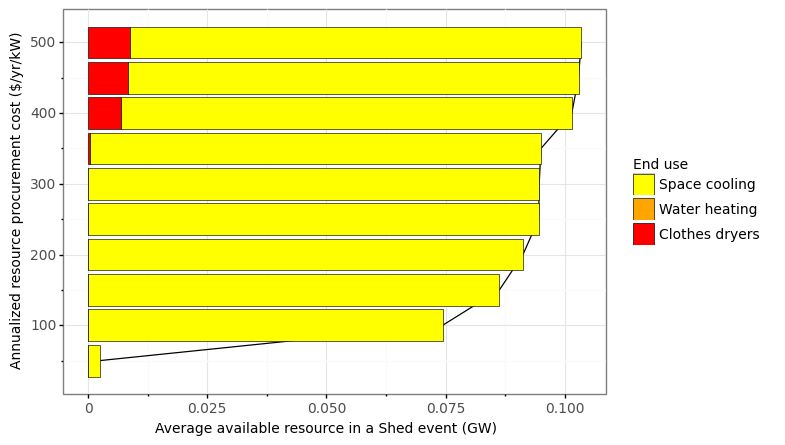

<ggplot: (8758137795788)>

In [13]:
from dr_path import plotting
plotting.plot_supply_curve_disagg(dem,tou,ren,tech, year=2016,timescale='year', 
                          dr_type='shed', bar_fill_by='end_use', 
                                  bar_colors=['red','orange','yellow','green','blue', 
                                              'indigo', 'violet'])

In [14]:
plotting.plot_barcharts(dem,tou,ren,tech, bar_by='sector', year=2016,timescale='year', 
                          dr_type='shed', fill_by='end_use', max_price=400,
                                  bar_colors=['red','orange','yellow','green','blue', 
                                              'indigo', 'violet'])

<ggplot: (-9223363278717043810)>

In [ ]:
for group2 in ['building_type', 'region','end_use']:
    features = clsf.groupby(['demand_scenario',group2])['value'].sum().div(1.e6).unstack(0)
    print(features.columns)
    features.columns=('Base', 'Equipment','Controls','Envelope','Cont.+Env.', 'All')
    features.to_csv(os.path.join(outdir, 'features_agg_by_{g}_{r}.csv'.format(g=group2,
                                                                              r=settings.REGION)))

    fig, ax = plt.subplots(figsize=(12,5))
    features.T.plot.bar(stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
                        fontsize=16, grid=True,
                        ax=ax)
    savings.plot(x='index', y='kwh_ann_tot', secondary_y=True, ax=ax, 
             marker='o', markersize=8, linestyle='', color='crimson', grid=True, fontsize=16)
    ax.set_axisbelow(True)
    ax.set_facecolor("lightgray")
    ax.set_ylabel('Shed DR Technical Potential (GW)', fontsize=16)
    ax.right_ax.set_ylabel('Relative Annual Electricity Consumption', fontsize=16)
    ax.set_xlabel(None)
    yl = ax.get_ylim()
    ax.right_ax.set_ylim([0, yl[1]/features['Base'].sum()])
    ax.legend(loc='upper left', bbox_to_anchor=[1.1,1], fontsize=14)
    plt.tight_layout()
    fig.savefig(os.path.join(outdir,'features_agg_by_{g}_{r}.png'.format(g=group2,
                                                                         r=settings.REGION)),
                dpi=300)

In [ ]:
models.database.close()

## Before proceeding, stop here and re-run all of the above cells for each region.

### Next we generate a joint plot for all regions

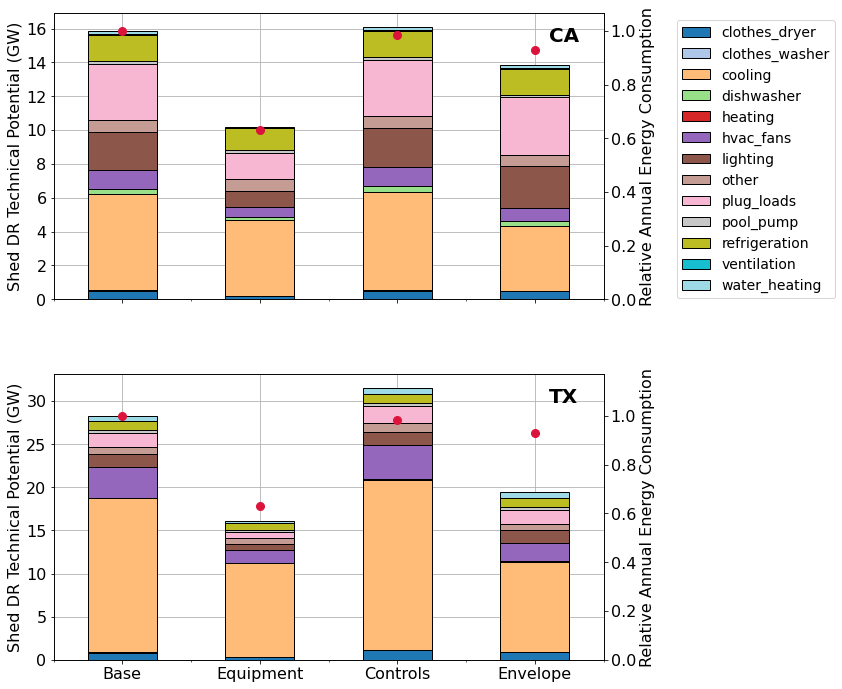

In [62]:
zero_env=False
fig, axs = plt.subplots(2,1, figsize=[12,10], sharex=True)
rs_map = {'CAMX':'CA', 'ERCT':'TX'}
for ax, reg in zip(axs, ['CAMX','ERCT']):
    features = pd.read_csv(os.path.join(outdir, 'features_agg_by_{g}_{r}.csv'.format(g='end_use',
                                                                                     r=reg)),
                          index_col='end_use')
    
    if (reg=='CAMX') & (zero_env):
        features[['Envelope', 'Cont.+Env.']]*= 0
    features[plot_ports].T.plot.bar(stacked=True, legend=False, cmap=plt.cm.get_cmap('tab20'), edgecolor='k', 
                        fontsize=16, grid=True,
                        ax=ax)
    savings.plot(x='index', y='kwh_ann_tot', secondary_y=True, ax=ax, legend=False, 
             marker='o', markersize=8, linestyle='', color='crimson', grid=True, fontsize=16)
    ax.set_axisbelow(True)
    ax.right_ax.set_ylabel('Relative Annual Energy Consumption', fontsize=16)
    ax.set_xlabel(None)
    yl = ax.get_ylim()
    ax.right_ax.set_ylim([0, yl[1]/features['Base'].sum()])
    #ax.set_facecolor("lightgray")
    ax.set_ylabel('Shed DR Technical Potential (GW)', fontsize=16)
    ax.text(0.9, 0.9, rs_map[reg], transform=ax.transAxes, fontsize=20, fontweight='bold')
axs[0].legend(loc='upper left', bbox_to_anchor=[1.12,1], fontsize=14)
#axs[1].legend(loc='upper left', bbox_to_anchor=[1.12,1], fontsize=14)
plt.tight_layout()
fig.savefig(os.path.join(outdir,'features_agg_by_{g}_{r}.png'.format(g='end_use',
                                                                     r='both')),
                dpi=300)



In [61]:
plt.cm.get_cmap('Set3')

## Check gross load shape
### (This can be skipped)

In [17]:
clusts = io.get_cluster_df(where=(models.Cluster.demand_scenario_id==1))
clusts

name     clustering_approach  \
id                                                                              
1   USA_CA_Arcata.725945_2016-Single-Family_Detach...  ResStockDryRun20200520   
2   USA_CA_Bakersfield.Meadows.723840_2016-Single-...  ResStockDryRun20200520   
3    USA_CA_Barstow.Daggett.723815_2016-Mobile_Home_0  ResStockDryRun20200520   
4   USA_CA_Barstow.Daggett.723815_2016-Single-Fami...  ResStockDryRun20200520   
5   USA_CA_Fresno.Air.Terminal.723890_2016-Single-...  ResStockDryRun20200520   
6   USA_CA_Long.Beach.Lb.Airp.722970_2016-Mobile_H...  ResStockDryRun20200520   
7   USA_CA_Long.Beach.Lb.Airp.722970_2016-Multi-Fa...  ResStockDryRun20200520   
8   USA_CA_Long.Beach.Lb.Airp.722970_2016-Multi-Fa...  ResStockDryRun20200520   
9   USA_CA_Long.Beach.Lb.Airp.722970_2016-Single-F...  ResStockDryRun20200520   
10  USA_CA_Long.Beach.Lb.Airp.722970_2016-Single-F...  ResStockDryRun20200520   
11  USA_CA_Los.Angeles.Intl.722950_2016-Multi-Fami...  ResStockDryRun20200520   
12  USA_CA_Los.Angeles.Intl.722950_2016-Multi-Fami...  ResStockDryRun20200520   
13  USA_CA_Los.Angeles.Intl.722950_2016-Single-Fam...  ResStockDryRun20200520   
14  USA_CA_Los.Angeles.Intl.722950_2016-Single-Fam...  ResStockDryRun20200520   
15  USA_CA_Sacramento.Executiv.724830_2016-Mobile_...  ResStockDryRun20200520   
16  USA_CA_Sacramento.Executiv.724830_2016-Multi-F...  ResStockDryRun20200520   
17  USA_CA_Sacramento.Executiv.724830_2016-Multi-F...  ResStockDryRun20200520   
18  USA_CA_Sacramento.Executiv.724830_2016-Single-...  ResStockDryRun20200520   
19  USA_CA_Sacramento.Executiv.724830_2016-Single-...  ResStockDryRun20200520   
20  USA_CA_San.Francisco.Intl.724940_2016-Mobile_H...  ResStockDryRun20200520   
21  USA_CA_San.Francisco.Intl.724940_2016-Multi-Fa...  ResStockDryRun20200520   
22  USA_CA_San.Francisco.Intl.724940_2016-Multi-Fa...  ResStockDryRun20200520   
23  USA_CA_San.Francisco.Intl.724940_2016-Single-F...  ResStockDryRun20200520   
24  USA_CA_San.Francisco.Intl.724940_2016-Single-F...  ResStockDryRun20200520   
25  USA_CA_Santa.Maria.Public.723940_2016-Single-F...  ResStockDryRun20200520   
26  USA_NV_Reno.Cannon.Intl.724880_2016-Single-Fam...  ResStockDryRun20200520   
27                                          com_other  ResStockDryRun20200520   
28                                          ind_other  ResStockDryRun20200520   

   sector                      region utility  customer_count  \
id                                                              
1     res               USA_CA_Arcata    CAMX            5763   
2     res  USA_CA_Bakersfield.Meadows    CAMX          117897   
3     res      USA_CA_Barstow.Daggett    CAMX           38968   
4     res      USA_CA_Barstow.Daggett    CAMX          209780   
5     res  USA_CA_Fresno.Air.Terminal    CAMX          249725   
6     res   USA_CA_Long.Beach.Lb.Airp    CAMX           84782   
7     res   USA_CA_Long.Beach.Lb.Airp    CAMX         1465553   
8     res   USA_CA_Long.Beach.Lb.Airp    CAMX          629952   
9     res   USA_CA_Long.Beach.Lb.Airp    CAMX            1339   
10    res   USA_CA_Long.Beach.Lb.Airp    CAMX         1444374   
11    res     USA_CA_Los.Angeles.Intl    CAMX          718479   
12    res     USA_CA_Los.Angeles.Intl    CAMX          706950   
13    res     USA_CA_Los.Angeles.Intl    CAMX             193   
14    res     USA_CA_Los.Angeles.Intl    CAMX          501253   
15    res  USA_CA_Sacramento.Executiv    CAMX           31228   
16    res  USA_CA_Sacramento.Executiv    CAMX          295096   
17    res  USA_CA_Sacramento.Executiv    CAMX          304891   
18    res  USA_CA_Sacramento.Executiv    CAMX           61884   
19    res  USA_CA_Sacramento.Executiv    CAMX         1038359   
20    res   USA_CA_San.Francisco.Intl    CAMX           10476   
21    res   USA_CA_San.Francisco.Intl    CAMX          747050   
22    res   USA_CA_San.Francisco.Intl    CAMX          539734   
23    res   USA_CA_San.Francisco.Intl    CAMX           44

In [18]:
tot_ls = io.get_load_shape_df(clusts.index, eu_names=['total'])
tot_ls

cluster             1              2             3              4   \
end_use          total          total         total          total   
loadshape          12             26            40             54    
0          3563.718183   70372.592471  24336.308683  151393.888132   
1          3349.223435   75715.638184  23861.387163  146191.723436   
2          3317.689283   71921.918260  24188.170420  147591.981539   
3          3333.408236   73988.718646  27023.341668  152647.435927   
4          3248.030297   73239.701679  24357.279660  154600.661069   
...                ...            ...           ...            ...   
8779       7663.151824  156260.377629  40646.473595  317870.917465   
8780       9134.700444  150929.631050  65956.526465  267990.952978   
8781       5848.603085  134190.421762  49624.973363  243202.709619   
8782       4699.546625  115427.010111  34843.388354  232198.405644   
8783       3921.318350   89858.964141  33068.055684  178324.704624   

cluster               5             6             7             8   \
end_use            total         total         total         total   
loadshape            68            82            96            110   
0          182493.681293  19713.900877  5.056597e+05  3.417499e+05   
1          169996.228791  17223.545468  4.625616e+05  2.536766e+05   
2          165500.473963  16108.833454  4.596640e+05  2.432764e+05   
3          165906.992264  15757.684903  4.586207e+05  2.370731e+05   
4          161880.191623  15344.059756  4.423646e+05  2.322569e+05   
...                  ...           ...           ...           ...   
8779       591447.654252  58766.524650  1.240392e+06  1.290676e+06   
8780       417673.541310  53857.915023  1.237869e+06  7.673306e+05   
8781       409854.380371  47601.015680  9.307004e+05  5.746841e+05   
8782       322706.422212  43324.808288  8.593113e+05  4.723628e+05   
8783       307745.534252  26908.972045  6.845892e+05  3.366341e+05   

cluster             9             10  ...            19            20  \
end_use          total         total  ...         total         total   
loadshape          124           138  ...           264           278   
0           534.042769  8.714333e+05  ...  1.870782e+06   7385.484682   
1           516.646644  9.511767e+05  ...  1.821960e+06   6866.938945   
2           506.932657  1.126433e+06  ...  1.934327e+06   6777.246240   
3           541.200748  1.249146e+06  ...  2.080531e+06   6681.180981   
4           558.784431  1.319767e+06  ...  2.173362e+06   6398.271526   
...                ...           ...  ...           ...           ...   
8779       1203.891418  2.518488e+06  ...  2.390657e+06  13884.670888   
8780       1137.964866  2.370292e+06  ...  2.318511e+06  13725.820702   
8781       1007.530274  2.140259e+06  ...  2.432378e+06  12732.375507   
8782        838.041353  2.184906e+06  ...  1.953694e+06  10563.556734   
8783        653.980376  1.633843e+06  ...  1.691142e+06   8523.541184   

cluster               21             22            23            24  \
end_use            total          total         total         total   
loadshape            292            306           320           334   
0          389355.420861  273914.463899  22207.963054  9.716244e+05   
1          366502.142172  270457.270573  21195.428115  9.314194e+05   
2          357955.171071  274534.115031  20665.341759  9.460821e+05   
3          355629.211662  284010.161791  20931.111770  9.970010e+05   
4          362788.828254  351266.087786  20956.032517  9.961431e+05   
...                  ...            ...           ...           ...   
8779       752220.607619  399676.290804  61681.321691  1.644039e+06   
8780       735269.000022  447901.489480  45925.897588  1.556337e+06   
8781       682741.863782  401075.859394  36746.310498  1.374979e+06   
8782       586780.969084  382732.970961  31189.660256  1.113985e+06   
8783       477829.141593  285353.541694  25726.596344  9.872899e+05   

cluster             

In [19]:
gls = pd.DataFrame(models.GrossLoadShape.get(id=1).hourly_kwh, index=range(1,8785))
gls

0
1     28929000.0
2     28117000.0
3     27229000.0
4     26570000.0
5     26267000.0
...          ...
8780  33034000.0
8781  31953000.0
8782  30737000.0
8783  29672000.0
8784  28627000.0

[8784 rows x 1 columns]

In [20]:
pd.DataFrame(tot_ls.sum(axis=1).values, index=range(1,8785))-gls

0
1     0.0
2     0.0
3     0.0
4     0.0
5     0.0
...   ...
8780  0.0
8781  0.0
8782  0.0
8783  0.0
8784  0.0

[8784 rows x 1 columns]

In [66]:
#Read input data from Cong
in_data = pd.read_csv("/mnt/g/Shared drives/BTO Topic 2  Integrating EE & DR/Task 2/Load_Shape_Data/ACEEE load/ResStock result(Dry-run on 05 07 2020)/Gross_load_CA_scenario_0_vs_1.csv", index_col=None)

In [73]:
tot_ls
#From the dataframe below, pick the last two columns to compare, in order, below. These are the
#total commercial and Other load. We are just making sure they match the expected input values.

cluster             1              2             3              4   \
end_use          total          total         total          total   
loadshape          12             26            40             54    
0          3563.718183   70372.592471  24336.308683  151393.888132   
1          3349.223435   75715.638184  23861.387163  146191.723436   
2          3317.689283   71921.918260  24188.170420  147591.981539   
3          3333.408236   73988.718646  27023.341668  152647.435927   
4          3248.030297   73239.701679  24357.279660  154600.661069   
...                ...            ...           ...            ...   
8779       7663.151824  156260.377629  40646.473595  317870.917465   
8780       9134.700444  150929.631050  65956.526465  267990.952978   
8781       5848.603085  134190.421762  49624.973363  243202.709619   
8782       4699.546625  115427.010111  34843.388354  232198.405644   
8783       3921.318350   89858.964141  33068.055684  178324.704624   

cluster               5             6             7             8   \
end_use            total         total         total         total   
loadshape            68            82            96            110   
0          182493.681293  19713.900877  5.056597e+05  3.417499e+05   
1          169996.228791  17223.545468  4.625616e+05  2.536766e+05   
2          165500.473963  16108.833454  4.596640e+05  2.432764e+05   
3          165906.992264  15757.684903  4.586207e+05  2.370731e+05   
4          161880.191623  15344.059756  4.423646e+05  2.322569e+05   
...                  ...           ...           ...           ...   
8779       591447.654252  58766.524650  1.240392e+06  1.290676e+06   
8780       417673.541310  53857.915023  1.237869e+06  7.673306e+05   
8781       409854.380371  47601.015680  9.307004e+05  5.746841e+05   
8782       322706.422212  43324.808288  8.593113e+05  4.723628e+05   
8783       307745.534252  26908.972045  6.845892e+05  3.366341e+05   

cluster             9             10  ...            19            20  \
end_use          total         total  ...         total         total   
loadshape          124           138  ...           264           278   
0           534.042769  8.714333e+05  ...  1.870782e+06   7385.484682   
1           516.646644  9.511767e+05  ...  1.821960e+06   6866.938945   
2           506.932657  1.126433e+06  ...  1.934327e+06   6777.246240   
3           541.200748  1.249146e+06  ...  2.080531e+06   6681.180981   
4           558.784431  1.319767e+06  ...  2.173362e+06   6398.271526   
...                ...           ...  ...           ...           ...   
8779       1203.891418  2.518488e+06  ...  2.390657e+06  13884.670888   
8780       1137.964866  2.370292e+06  ...  2.318511e+06  13725.820702   
8781       1007.530274  2.140259e+06  ...  2.432378e+06  12732.375507   
8782        838.041353  2.184906e+06  ...  1.953694e+06  10563.556734   
8783        653.980376  1.633843e+06  ...  1.691142e+06   8523.541184   

cluster               21             22            23            24  \
end_use            total          total         total         total   
loadshape            292            306           320           334   
0          389355.420861  273914.463899  22207.963054  9.716244e+05   
1          366502.142172  270457.270573  21195.428115  9.314194e+05   
2          357955.171071  274534.115031  20665.341759  9.460821e+05   
3          355629.211662  284010.161791  20931.111770  9.970010e+05   
4          362788.828254  351266.087786  20956.032517  9.961431e+05   
...                  ...            ...           ...           ...   
8779       752220.607619  399676.290804  61681.321691  1.644039e+06   
8780       735269.000022  447901.489480  45925.897588  1.556337e+06   
8781       682741.863782  401075.859394  36746.310498  1.374979e+06   
8782       586780.969084  382732.970961  31189.660256  1.113985e+06   
8783       477829.141593  285353.541694  25726.596344  9.872899e+05   

cluster             

In [74]:
in_data['scaled_com_kwh']-tot_ls[27, 'total',366].values

0       0.000000e+00
1       0.000000e+00
2       0.000000e+00
3       0.000000e+00
4      -9.313226e-10
            ...     
8779    0.000000e+00
8780    0.000000e+00
8781    0.000000e+00
8782    0.000000e+00
8783    0.000000e+00
Name: scaled_com_kwh, Length: 8784, dtype: float64

In [75]:
in_data['scaled_other_load/KW']-tot_ls[28, 'total', 368].values

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
8779    0.0
8780    0.0
8781    0.0
8782    0.0
8783    0.0
Name: scaled_other_load/KW, Length: 8784, dtype: float64

In [90]:
models.database.close()

True

In [36]:
{'a':0} + {'b':1}

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'